# TP Active Contour : Part 2 Level Set

## Nom : Abdennour Kerboua (Fait seul)

In [1]:
import numpy as np
import matplotlib
import skimage
import IPython
import imagecodecs #(New 2025) 


import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation, rc

from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour # For active_contour function
from skimage.util import random_noise

# For active_contour function
from skimage.segmentation import chan_vese, morphological_chan_vese, checkerboard_level_set,morphological_geodesic_active_contour

# For some image filtering
from skimage.morphology import white_tophat, black_tophat, disk

import skimage.io 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# PRINT VERSIONS
print("np.__version__",np.__version__)
print("matplotlib.__version__",matplotlib.__version__)
print("skimage.__version__",skimage.__version__)
print("IPython.__version__",IPython.__version__)
print("imagecodecs.__version__",imagecodecs.__version__)

np.__version__ 2.0.2
matplotlib.__version__ 3.9.2
skimage.__version__ 0.24.0
IPython.__version__ 8.27.0
imagecodecs.__version__ 2024.12.30


In [2]:
def edge_map(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.sobel(blur)

def edge_map2(img,sigma):
    blur = skimage.filters.gaussian(img,sigma)
    return skimage.filters.scharr(blur)

def subtract_background(image, radius=5, light_bg=False):
        str_el = disk(radius) 
        if light_bg:
            return black_tophat(image, str_el)
        else:
            return white_tophat(image, str_el)

        
def define_initial_circle(R0,r0,c0,Nber_pts=400):
    # Define initial contour shape
    s      = np.linspace(0, 2*np.pi, Nber_pts)
    Radius = R0  
    r      = r0 + Radius*np.sin(s)
    c      = c0 + Radius*np.cos(s) #col
    init   = np.array([r, c]).T
    return init


## Create slides for animation
def animate_cv(image, segs, interval=1000):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image, cmap='gray');
    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    ax.axis('off')

    def init():
        im.set_data(segs[0])
        return [im]

    def animate(i):
        im.set_array(segs[i])
        return [im]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim


def animate_snake(image, segs, interval=500):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray');
    #    im = ax.imshow(segs[0], alpha=0.5, cmap='inferno');
    #ax.plot(segs[0][:, 1], segs[0][:, 0], '--r', lw=3)
    ax.axis('off')
    line, = ax.plot([], [], '-r', lw=2)

    def init():
        line.set_data(segs[0,:,1],segs[0,:,0])
        return [line,]

    def animate(i):
        line.set_data(segs[i,:,1],segs[i,:,0])
        return [line,]

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(segs), interval=1000, blit=True);
    return anim



###########################
def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Read images

This part reads a series of images that you can then use in various tests. <br>
Note that some images are provided with ground-truth masks of structures of interest:<br>
1. OCT_tissue
2. CTabd (CT of the abdomen)
3. US nodule (Ultrasound image with a nodule)
4. images_blood_cells/000016.png [several images available]


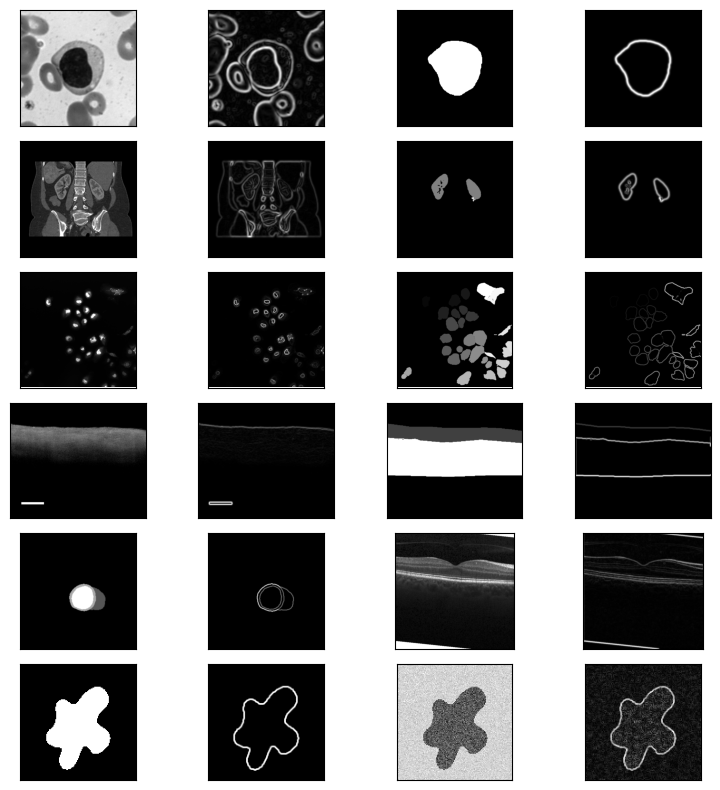

In [12]:
# import warnings
# warnings.filterwarnings( "ignore", module = "matplotlib\..*" )
# skimage.io.imshow(img_mask)

# Binary images  - w/o ground truth
img_star          = skimage.io.imread('./images_misc/smooth_star.png', as_gray = True)
edge_star         = edge_map(img_star, sigma=0)
img_star_noisy    = skimage.io.imread('./images_misc/smooth_star_noisy.png', as_gray = True)
edge_star_noisy   = edge_map(img_star_noisy, sigma=0)
img_binshape      = skimage.io.imread('./images_misc/binary_shape_2024.png', as_gray = True)
edge_binshape     = edge_map(img_binshape, sigma=0)
img_cardiacshape  = skimage.io.imread('./images_misc/cardiac_mri_mask.png', as_gray = True)
edge_cardiacshape = edge_map(img_cardiacshape, sigma=0)

# Microscopy images - w/o ground truth # line changed 2025
img_hela          = skimage.io.imread('./images_misc/hela_big.png')


# OCT eye images  - w/o ground truth
img_oct_eye  = skimage.io.imread('./images_misc/OCT_normal.jpeg', as_gray = True)
img_oct_eye  = np.squeeze(img_oct_eye)
img_oct_eye  = img_oct_eye.astype('float64')
img_oct_eye  = img_oct_eye/np.max(img_oct_eye)

edge_oct_eye = edge_map(img_oct_eye, sigma=2)

# CT abdo images  - with ground truth
img_CTabd     = skimage.io.imread('./images_misc/CT_kidney_im.png', as_gray = True)
edge_CTabd    = edge_map(img_CTabd, sigma=2)
gt_CTabd      = skimage.io.imread('./images_misc/CT_kidney_mask.png', as_gray = True)
edge_gt_CTabd = edge_map(gt_CTabd, sigma=2)


# Cell images  - with ground truth
img_cell  = skimage.io.imread('./images_blood_cells/0000152.png', as_gray = True)
edge_cell = edge_map(img_cell, sigma=2)
#skimage.io.imshow(img_cell)
gt_cell = skimage.io.imread('./masks_blood_cells/0000152.png', as_gray = True)
edge_gt_cell = edge_map(gt_cell, sigma=2)

# Cell image - challenge multi
img_cell2     = skimage.io.imread('./images_misc/cell_00236.tif', as_gray = True)
edge_cell2    = edge_map(img_cell2, sigma=2)
gt_cell2      = skimage.io.imread('./images_misc/cell_00236_label.tiff', as_gray = True)
edge_gt_cell2 = edge_map(gt_cell2, sigma=2)

# Hela Cell image - Cell tracking challenge 
img_helat1     = skimage.io.imread('./images_misc/hela_t001.tif', as_gray = True)
edge_helat1    = edge_map(img_helat1, sigma=2)
gt_helat1      = skimage.io.imread('./images_misc/hela_mask001.tif', as_gray = True)
edge_gt_helat1 = edge_map(gt_helat1, sigma=2)

# Fluo Cell image - Cell tracking challenge 
img_fluo     = skimage.io.imread('./images_misc/fluo000.tif', as_gray = True)
edge_fluo    = edge_map(img_fluo, sigma=2)
gt_fluo      = skimage.io.imread('./images_misc/fluo000_seg.tif', as_gray = True)
edge_gt_fluo = edge_map(gt_fluo, sigma=2)


# OCT image of tissue  - with ground truth
img_oct_tissue  = skimage.io.imread('./OCT_myocardium/case272.tif', as_gray = True)
edge_oct_tissue = edge_map(img_oct_tissue, sigma=2)
gt_oct_tissue  = skimage.io.imread('./OCT_myocardium/case272_label.tiff', as_gray = True)
edge_gt_oct_tissue = edge_map(gt_oct_tissue, sigma=2)

# US image of a nodule  - with ground truth
img_USnodule  = skimage.io.imread('./thyroid_nodule/1074.png', as_gray = True)
edge_USnodule = edge_map(img_USnodule, sigma=2)
gt_USnodule   = skimage.io.imread('./thyroid_nodule/1074_mask.png', as_gray = True)
edge_gt_USnodule = edge_map(gt_USnodule, sigma=2)

# PLOTS

fig, axes = plt.subplots(6,4, figsize=(8, 8))
ax = axes.ravel()

ax[0].imshow(img_cell, cmap=plt.cm.gray);
ax[1].imshow(edge_cell, cmap=plt.cm.gray);
ax[2].imshow(gt_cell, cmap=plt.cm.gray);
ax[3].imshow(edge_gt_cell, cmap=plt.cm.gray);

ax[4].imshow(img_CTabd, cmap=plt.cm.gray);
ax[5].imshow(edge_CTabd, cmap=plt.cm.gray);
ax[6].imshow(gt_CTabd, cmap=plt.cm.gray);
ax[7].imshow(edge_gt_CTabd, cmap=plt.cm.gray);

ax[8].imshow(img_fluo, cmap=plt.cm.gray);
ax[9].imshow(edge_fluo, cmap=plt.cm.gray);
ax[10].imshow(gt_fluo, cmap=plt.cm.gray);
ax[11].imshow(edge_gt_fluo, cmap=plt.cm.gray);

ax[12].imshow(img_oct_tissue, cmap=plt.cm.gray);
ax[13].imshow(edge_oct_tissue, cmap=plt.cm.gray);
ax[14].imshow(gt_oct_tissue, cmap=plt.cm.gray);
ax[15].imshow(edge_gt_oct_tissue, cmap=plt.cm.gray);

ax[16].imshow(img_cardiacshape, cmap=plt.cm.gray);
ax[17].imshow(edge_cardiacshape, cmap=plt.cm.gray);

ax[18].imshow(img_oct_eye, cmap=plt.cm.gray);
ax[19].imshow(edge_oct_eye, cmap=plt.cm.gray);

ax[20].imshow(img_star, cmap=plt.cm.gray);
ax[21].imshow(edge_star, cmap=plt.cm.gray);
ax[22].imshow(img_star_noisy, cmap=plt.cm.gray);
ax[23].imshow(edge_star_noisy, cmap=plt.cm.gray);

for i in range(0,24):
    ax[i].set_xticks([]), ax[i].set_yticks([]);
fig.tight_layout()
plt.show();


# Image properties: 
## Range of values and data type matter ...


Some routines won't work if your image type is int8 or uint8...
Here is how to check your image data type

And regularly check your image content in terms of:
* intensities range of values
* distributions of intensities via its histogram


Image size of img_test is:  (256, 256)
Data type of img_test is:  float64
min - max value in image: 0.06550980392156862 0.5724509803921568


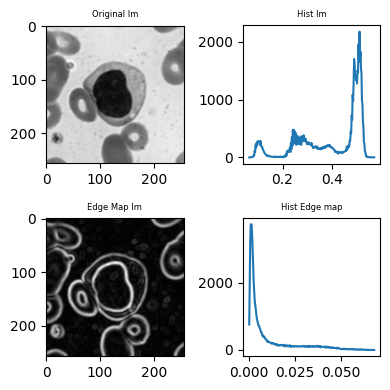

In [4]:

img_test  = img_cell #img_star_noisy#img_oct_eye #img_CTabd #img_cell
Sigma_val = 2
edge_test = edge_map(img_test, sigma=Sigma_val)


## Print some basic image properties
print("Image size of img_test is: ", img_test.shape)
print("Data type of img_test is: ", img_test.dtype)
print("min - max value in image:" , np.min(img_test), np.max(img_test))


## Hot to plot a Histogram
hist_test, bins_test             = np.histogram(img_test.flatten(), bins=256)
hist_edge_test, bins_edges_test  = np.histogram(edge_test.flatten(), bins=256)

fig, axes = plt.subplots(2,2, figsize=(4, 4))
ax        = axes.ravel()
ax[0].imshow(img_test, cmap=plt.cm.gray);
ax[0].set_title("Original Im", fontsize=6);
ax[1].plot(bins_test[0:-1],hist_test);
ax[1].set_title("Hist Im", fontsize=6);
ax[2].imshow(edge_test, cmap=plt.cm.gray);
ax[2].set_title("Edge Map Im", fontsize=6);
ax[3].plot(bins_edges_test[0:-1],hist_edge_test);
ax[3].set_title("Hist Edge map", fontsize=6);
fig.tight_layout()
plt.show();



# Edge maps
Deformable models rely on edge maps. Most routines have their own strategy coded to compute the edge map. 

* Edge maps usually involve smoothing of the image, to be robust to noise. Make sure you understand how this is controlled in the routine you use. 
* Edge maps usually show pixels with high gradient magnitudes in white (high values)
* Most deformable model routines can be fed directly with an Edge Map rather than the original image as its input
* Some routine expect to be fed with an inverse edge map where high gradient locations have small values, to stop the contour via a velocity set to ~zero. 

Data type of img_test is:  float64
min - max value in image: 0.06550980392156862 0.5724509803921568


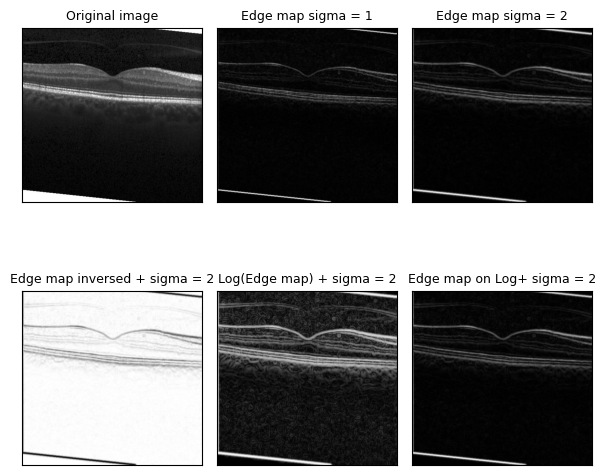

In [5]:

img_to_test = img_oct_eye 
print("Data type of img_test is: ", img_test.dtype)
print("min - max value in image:" , np.min(img_test), np.max(img_test))

Font_size  = 9

# Classic Edge map with Gaussian smoothing controled by sigma
edge_test1         = edge_map(img_to_test, sigma=1)
edge_test2         = edge_map(img_to_test, sigma=2)
edge_test2_l       = np.log2((edge_test2*100)+1)
edge_testl_2       = edge_map(np.log2((img_to_test+1)*100), sigma=2)

# Inversed Edge map
# Returns Edge map = 1.0 / np.sqrt(1.0 + alpha * gradnorm)
edge_inv_test  = skimage.segmentation.inverse_gaussian_gradient(img_to_test, alpha=1.0, sigma=2.0) 


fig, axes = plt.subplots(2,3, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(img_to_test, cmap=plt.cm.gray);
ax[0].set_title("Original image", fontsize=Font_size);
ax[1].imshow(edge_test1, cmap=plt.cm.gray);
ax[1].set_title("Edge map sigma = 1", fontsize=Font_size);
ax[2].imshow(edge_test2, cmap=plt.cm.gray);
ax[2].set_title("Edge map sigma = 2", fontsize=Font_size);
ax[3].imshow(edge_inv_test, cmap=plt.cm.gray);
ax[3].set_title("Edge map inversed + sigma = 2", fontsize=Font_size);
ax[4].imshow(edge_test2_l, cmap=plt.cm.gray);
ax[4].set_title("Log(Edge map) + sigma = 2", fontsize=Font_size);
ax[5].imshow(edge_testl_2, cmap=plt.cm.gray);
ax[5].set_title("Edge map on Log+ sigma = 2", fontsize=Font_size);

for i in range(0,6):
    ax[i].set_xticks([]), ax[i].set_yticks([]);

fig.tight_layout()
plt.show();

# Image transforms

Let you test some image transformations based on morphological operators and histogram manipulation. 
When transforming image contrast, it is always interesting to look at the differences between the original image and the transformed version.

/var/folders/x3/c14j1vdn7wj4znv2cghvl0cc0000gn/T/ipykernel_24491/2933326377.py:64: RuntimeWarning: divide by zero encountered in log2
  tmp_show = ax[9].imshow(np.log2(abs(img_to_test-img_test2+img_eps)), cmap=plt.cm.gray);


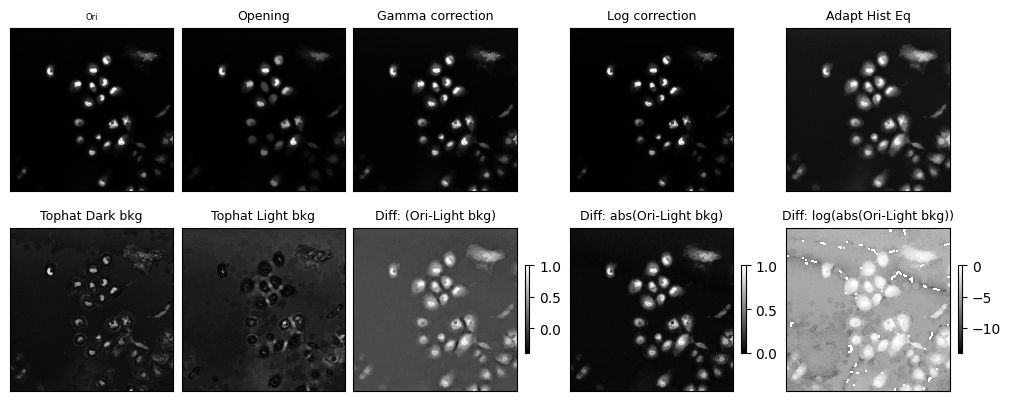

In [6]:
img_ori_to_test = img_fluo #img_CTabd #img_oct_eye #img_CTabd 
img_to_test     = img_ori_to_test
epsilon         = 0.000001 #to prevent log on 0 
img_eps         = np.full_like(img_to_test, epsilon)
PRE_ENHANCE     = 1
OPTION_ENHANCE  = 4 # can be 0 (nothing) OR 1,2,3,4 for different enchancement options
Font_size  = 9

# Run all  OPTION_ENHANCE for display here       
gamma_corrected       = skimage.exposure.adjust_gamma(img_to_test, 0.8)
logarithmic_corrected = skimage.exposure.adjust_log(img_to_test, gain= 1,inv=True)
img_open              = skimage.morphology.diameter_opening(img_to_test, 40, connectivity=2)
img_adapteq           = skimage.exposure.equalize_adapthist(img_to_test, clip_limit=0.03)

# PRE ENHANCEMENT OPTIONS:
if PRE_ENHANCE==1:
    if OPTION_ENHANCE==1:
        # Gamma
        img_to_test     = gamma_corrected
    elif OPTION_ENHANCE==2:
        # Logarithmic (O = gain*log(1 + I)) or if Inv (O = gain*(2**I - 1))
        img_to_test           = logarithmic_corrected
    elif OPTION_ENHANCE==3:
        # Morpho Opening
        img_to_test           = img_open
    elif OPTION_ENHANCE==4:
        # Contrast Limited Adaptive Histogram Equalization (CLAHE).
        img_to_test           = img_adapteq

# Enhance details either dark around light background of vice versa with the Top-Hat transform
Radius_val = 15
img_test1  = subtract_background(img_to_test, radius=Radius_val, light_bg=False)
img_test2  = subtract_background(img_to_test, radius=Radius_val, light_bg=True)

# SHOW OUTPUTS
fig, axes = plt.subplots(2,5, figsize=(10, 4),constrained_layout=True)
ax        = axes.ravel()
Shrink_factor_colormap = 0.5
ax[0].imshow(img_ori_to_test, cmap=plt.cm.gray);
ax[0].set_title("Ori", fontsize=6);

ax[1].imshow(img_open, cmap=plt.cm.gray);
ax[1].set_title("Opening", fontsize=Font_size);
ax[2].imshow(gamma_corrected, cmap=plt.cm.gray);
ax[2].set_title("Gamma correction", fontsize=Font_size);
ax[3].imshow(logarithmic_corrected, cmap=plt.cm.gray);
ax[3].set_title("Log correction", fontsize=Font_size);
ax[4].imshow(img_adapteq, cmap=plt.cm.gray);
ax[4].set_title("Adapt Hist Eq", fontsize=Font_size);

ax[5].imshow(img_test1, cmap=plt.cm.gray);
ax[5].set_title("Tophat Dark bkg", fontsize=Font_size);
ax[6].imshow(img_test2, cmap=plt.cm.gray);
ax[6].set_title("Tophat Light bkg", fontsize=Font_size);

tmp_show = ax[7].imshow(img_to_test-img_test2, cmap=plt.cm.gray);
ax[7].set_title("Diff: (Ori-Light bkg)", fontsize=Font_size);
plt.colorbar(tmp_show,ax=ax[7], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[8].imshow(abs(img_to_test-img_test2), cmap=plt.cm.gray);
ax[8].set_title("Diff: abs(Ori-Light bkg)", fontsize=Font_size);
plt.colorbar(tmp_show,ax=ax[8], shrink=Shrink_factor_colormap, location='right')

tmp_show = ax[9].imshow(np.log2(abs(img_to_test-img_test2+img_eps)), cmap=plt.cm.gray);
ax[9].set_title("Diff: log(abs(Ori-Light bkg))", fontsize=Font_size);
plt.colorbar(tmp_show,ax=ax[9], shrink=Shrink_factor_colormap, location='right')

for i in range(0,10):
    ax[i].set_xticks([]), ax[i].set_yticks([]);
    
#fig.tight_layout() # not compatible with option constrained_layout=True in plt.subplots needed to display the colorbar
plt.show();


# Seg #1: 
### Snake on a binary shape + noise effects

This part of the practical work uses the routine **active_contour** from skimage. <br>
Default **parameter values** are: <br>
* alpha=0.01  (Snake length shape parameter. Higher values makes snake contract faster.)
* beta=0.1    (Snake smoothness shape parameter. Higher values makes snake smoother.)
* gamma=0.01  (Explicit time stepping parameter - Equivalent to the viscosity of the environment)
* max_px_move=1.0
<br>

There are two **other parameters** that define the final image information used to define external forces used to define regions.img = w_line x img + w_edge x edge: <br> 
*   w_line_val= 0 (default) | =1 if want to input_edge map directly. Use negative values to attract toward dark 
*   w_edge_val= 1 (default)  | = 0 if do not want to use internal edge map. Use negative values to repel snake from edges

 
## TODO:
**Provide answers in text boxes**
***
__Q1.1__. Run the code for **img_to_seg=img_cardiacshape** using **img_ori** and all parameter values as provided, except for changing the R0 value. 
Comment on behavior for:<br>
- R0=10: 
- R0=20:  
- R0=30:  
- R0=50:  
***
***
__Q1.2__. For R0=30 test the segmentation without smoothing and then with Niter_smooth = 1 and 2. Comment on the segmentation quality for: <br>
- no smoothing:       
- Niter_smooth = 1:   
- Niter_smooth = 2:   
***
***
__Q1.3__. Now run the segmentation on the **noisy version** or the image. 2 types of noise are simulated: (1) Additive Gaussian noise, (2) Speckle (multiplicative) noise. <br>
__Q1.3.1__ Check **appearance** of the 2 noisy images. Why is there no noise in the background in the speckle case? <br>
__Answer__: 
<br>
__Q1.3.2__ Using **R0=50**, run the segmentation on the noisy images **without** and with **smoothing** (Niter_smooth= 1). Comment on segmentation quality or issues for the 4 observations:  
- Speckle noise + no smoothing:  <br>
- Speckle noise +  smoothing:  <br>
- Gaussian noise + no smoothing:  <br>
- Gaussian noise +  smoothing:  <br>
***

In [ ]:
# 1ST image
img_ori          = img_cardiacshape; r0 = 175; c0=175; R0 = 10 
img_noisy        = random_noise(img_ori, mode='gaussian', mean = 0.1,clip = True)
img_noisy        = random_noise(img_ori, mode='speckle', mean = 0.1,clip = True)

# Choose image to segment
img_to_seg     = img_ori
img_to_seg_raw = img_to_seg # to plot later on

alpha_val  = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
convergence_val = 1e-4;Niter_snake = 1800; 


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Pre-smooth the image 
Niter_smooth    = 1 # set to 0 for no smoothing
img_to_seg      = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Run active contour 
snake1  = active_contour(img_to_seg,
                       init, max_num_iter=1, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake10 = active_contour(img_to_seg,
                       init, max_num_iter=10, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake_max = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val, 
                           alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, axes = plt.subplots(1,2, figsize=(8, 4),constrained_layout=True)
ax        = axes.ravel()
Font_size = 9
ax[0].imshow(img_to_seg_raw, cmap=plt.cm.gray);
ax[0].set_xticks([]), ax[0].set_yticks([]);
ax[0].set_title("Image to segment", fontsize=Font_size);

ax[1].imshow(img_to_seg, cmap=plt.cm.gray);
ax[1].plot(init[:, 1], init[:, 0], '--y', lw=1);
ax[1].plot(snake10[:, 1], snake1[:, 0], '-b', lw=1);
ax[1].plot(snake10[:, 1], snake10[:, 0], '-g', lw=1);
ax[1].plot(snake_max[:, 1], snake_max[:, 0], '-r', lw=2);
ax[1].set_xticks([]), ax[1].set_yticks([]);
ax[1].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0]);
ax[1].set_title("Smoothed image + Seg", fontsize=Font_size);

plt.show();

# Seg #2: 
### Snake on Cell image 

We are using here **img_to_seg   = img_cell** for which you have a ground truth mask **gt_cell** of the target segmentation for the bright right cell.  

## TODO
***
__Q2.1__ **Segment large right  cell**: 
Run with code as provided and check quality of the segmentation versus the ground-truth. Did it work? <br>
**Answer**:  <br> 
***

***

__Q2.2__ Now aiming to segment the internal dark part of the cell: change only values for Niter_smooth and R0 and propose a solution that works. <br>
**Answer**: managed to obtain a correct segmentation with Niter_smooth = XX and R0 = XX <br>
***

***
__Q2.3__ **Segment small left cell**:
Run with the proposed initialisation and check correct segmentation of the whole left cell.
Now change ONLY some initial contour parameter(s) **\[r0 = 153; c0=66; R0 = 25\]** to obtain a perfect segmentation of the internal bright center of the cell. <br>
**Answer**: managed to obtain a correct segmentation with \[r0 = XX; c0=XX; R0 = XX\] <br>
***



In [ ]:

# Input image and parameter values
img_to_seg   = img_cell; 
img_gt       = gt_cell;

# Large rigt cell - ground truth provided
r0 = 128; c0=128; R0 = 53 
# Small left cell - no ground truth
#r0 = 153; c0=66; R0 = 25


alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 1200;


# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)


# Initialise contour 
init = define_initial_circle(R0,r0,c0)

# Run active contour 
snake30 = active_contour(img_to_seg,
                       init, max_num_iter=30, convergence=convergence_val, 
                         alpha=alpha_val, beta=beta_val, gamma=gamma_val)
snake = active_contour(img_to_seg,
                       init, max_num_iter=Niter_snake, convergence=convergence_val, 
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val)

# Display results 
fig, axes = plt.subplots(1,2, figsize=(8, 4),constrained_layout=True)
ax        = axes.ravel()
Font_size = 9

ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
ax[0].plot(init[:, 1], init[:, 0], '--y', lw=1)
ax[0].plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax[0].plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax[0].set_xticks([]), ax[0].set_yticks([])
ax[0].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

ax[1].imshow(img_gt, cmap=plt.cm.gray)
ax[1].plot(init[:, 1], init[:, 0], '--y', lw=1)
ax[1].plot(snake30[:, 1], snake30[:, 0], '-b', lw=1.5)
ax[1].plot(snake[:, 1], snake[:, 0], '-r', lw=2)
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[1].axis([0, img_to_seg.shape[1], img_to_seg.shape[0], 0])

plt.show();

# Seg # 3

### A tool to visualise the deformations of the snake over iterations


## TO DO:
Run the code with provided parameter values. <br>
***
__Q3.1__ Checking the video, would you confirm that the snake has converged and is stable?<br>
**Answer**: <br>

***

__Q3.2__ Change R0 to R0 = 52. Has convergence time been shorter or longer? Did you expect such observation (yes/no)? <br>
**Answer**: convergence time shorter/longer. It was (not?) expected since XX... <br>

In [ ]:
img_to_seg        = img_cell
img_to_seg_ori    = img_to_seg

# Init to segment cell
r0 = 128; c0=128; R0 = 53
alpha_val = 0.01 ; beta_val = 0.1 ;gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 800;



# Pre filter the image
img_adapteq = skimage.exposure.equalize_adapthist(img_to_seg, clip_limit=0.03)
#img_to_seg = img_adapteq

# Pre smooth the image
Niter_smooth = 1
img_to_seg   = gaussian(img_to_seg, Niter_smooth, preserve_range=False)

# Initialise contour 
init = define_initial_circle(R0,r0,c0)


# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,20):
    print(i, " ", end='')
    segs.append(active_contour(img_to_seg, init, max_num_iter=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(img_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 4

### Snake with  Gradient Vector Flow (GVF)
This implementation of the GVF is performed by computing the edge map, diffusing the gradient over the whole image and directly input the GVF_edge_map to be used as external forces by setting w_line=1 and w_edge=0 in the active_contour function.

## TODO: 
***
__Q4.1.1__ Report the visual differences in the GVF_map between mu=5 and mu=15. <br>
**Answer**: <br>

__Q4.1.2__ What is the mu parameter controling? <br>
**Answer**: The mu parameter controls for XX. <br>
***
***
__Q4.2__ Why does mu=15 enable to obtain a correct segmentation? <br>
**Answer**: <br>
***
***
__Q4.3__ Report what happens when segmenting with the classic Edge_map rather than the GVF_map. <br>
**Answer**: <br>
***

In [ ]:
import gvf_elsa2
from gvf_elsa2 import  gradient_field, gradient_vector_flow


# Image to seg
img_to_seg = img_star
r0 = 64; c0=64; R0 = 50

alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 200; 


# Initialise contour 
init        = define_initial_circle(R0,r0,c0,Nber_pts=400)

# Compute edge map and gvf
img_to_seg = img_to_seg.astype(np.float32) / np.max(img_to_seg)
Edge_map   = edge_map(img_to_seg,sigma=1)

fx, fy = gradient_field(img_to_seg) 
gx, gy = gradient_vector_flow(fx, fy, mu=5)
GVF_map = np.sqrt(gx**2 + gy**2)

# Run active contour while saving intermediate contours to see deformations
Map_to_seg = Edge_map

# Run active contour while saving intermediate contours to see deformations
segs = []
print('start')
for i in range(1,Niter_snake,10):
    print(i, " ", end='')
    segs.append(active_contour(Map_to_seg, init, max_num_iter=i, convergence=convergence_val, 
                alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                    w_line=1,w_edge=0))

print('stop')
np.save('ANIM_contours.npy', np.array(segs))

# display animation
segs = np.load('ANIM_contours.npy')
anim = animate_snake(Map_to_seg, segs);
HTML(anim.to_html5_video())

# Seg # 5:

### The active contour with fixed end points
You will now run the active_contour with the option to maintain some points from the inital contour fixed. You are working with the **img_oct_eye** which shows different layers of the retina. The **active_contour** routine is called to used directly the **Edge_map** as input.   

## TO DO:
***
__Q5.1__ Rank the 4 options for the Edge_map options from top to worst to segment the two layers wrt to segmentation quality and robustness to leyer selection.   <br>
__Answer__: Ranked Edge_map options from best to worst: <br>
1. edge_test1 <br>
2. edge_test2 <br>
3. edge_test2_l <br>
4. edge_testl_2 <br>
***

In [ ]:

img_to_seg = img_oct_eye

# init for 1st layer
r_left = 103; r_right=138; c_left=0; c_right = 510
# init for 2nd layer
#r_left = 158; r_right=204; c_left=0; c_right = 510


alpha_val  = 0.01 ; beta_val = 0.1; gamma_val = 0.01; 
convergence_val = 1e-4; Niter_snake = 500;
w_line_val=1; w_edge_val=0;

# Computation of edge maps
edge_test1         = edge_map(img_to_seg, sigma=1)
edge_test2         = edge_map(img_to_seg, sigma=2)
edge_test2_l       = np.log2((edge_test2*100)+1)
edge_testl_2       = edge_map(np.log2((img_to_seg+1)*100), sigma=2)

# Selection of edge_map to use 
Edge_map           = edge_test1

# Initialise contour 
Nber_pts_contour = 200
r          = np.linspace(r_left, r_right, Nber_pts_contour)
c          = np.linspace(c_left, c_right, Nber_pts_contour)
init       = np.array([r, c]).T


snake = active_contour(Edge_map,
                       init, boundary_condition='fixed-fixed',max_num_iter=Niter_snake,
                       alpha=alpha_val, beta=beta_val, gamma=gamma_val,
                       w_line=w_line_val, w_edge=w_edge_val)


# FIGURE

fig, ax = plt.subplots(figsize=(9, 5));
ax.imshow(Edge_map[0:300,:], cmap=plt.cm.gray);
ax.plot(init[:, 1], init[:, 0], '--y', lw=2);
ax.plot(snake[:, 1], snake[:, 0], '-r', lw=3);
ax.set_xticks([]), ax.set_yticks([]);
ax.set(xlim=(0, 500));
plt.show();

# Seg # 6
BONUS - Optional
### Your turn on proposing a motivated pipeline using the snake capabilities from the active_contour function

## TODO: 
Choose a new image in the pool provided and propose a segmentation pipeline using the active_contour approach. Options on points to work on include: <br>
* Pre-filter the image as you wish
* Manually or automatically position the initial contour
* Provide one segmentation result or merge several solutions in a probability map
* Detect issues in contour shape during deformations and propose an early stop criteria. 


***
__Q6__ Provide  code + visual illustrations of results <br>
__Answer__ 
***

# Seg #7

### Test on the Geometric Level-Set formulation using the Chan-Vese model. 
Skimage provides two implementations of the Chan-Vese approach: <br>
**[1] chan_vese**: implementation or original paper <br>
and <br>
**[2] morphological_chan_vese**: faster implementation but less precise. "Active contours without edges implemented with morphological operators. It is required that the inside of the object looks different on average than the outside (i.e., the inner area of the object should be darker or lighter than the outer area on average)." <br>

The contours of objects are now encoded in a level set function **Phi**.

The **initialisation** tested here is with a "checkerboard" pattern for 2 classes (object and background). <br>

For the **chan_vese** original implementation, the **hyper-parameters** include:<br>
* mu = 0.25 (default) | edge regularisation terms. Similar to ‘edge length’ weight parameter. Higher mu values will produce ‘smoother’ contours.
* dt = 0.5 (default) |  delta time step for each optimisation step.  
* lambda1=1, lambda2=1 (default) | weights in the cost metric to balance inside and outside homogeneity terms. 
* tol=1e-3 (default) | Tolerance to test if the contours are "stable" and stop early.

The output contains: cv[0]=Seg and cv[1]=Phi <br>

For the **morphological_chan_vese**  implementation, the only **hyper-parameter** is the number of smoothing iterations (1 to 4 recommended).<br>

## TO DO:
Using __Chan-Vese__ original implementation: <br>
***
__Q7.1__  Run the code on __img_hela__ with 200 iterations using __raw image__ and the same image after __histogram equalisation__. What are differences observed in the Segmentation results and in the numerical values of the Phi level set function? <br>
__Answer__:   <br>
Differences in the segmentation results: En égalisant l'histogramme de l'initialisation, le contour final est beaucoup plus régulier. De plus, l'image étant plus contrasté la segmentation est plus nette et compacte.   <br>
Differences in the Phi values: Sans l'égalisation, la fonction $\Phi$ est plus irrégulière et est très proche de sa forme initiale de damier sur $\Omega$. Avec l'égalisaiton, les valeurs de la fonction $\Phi$ semblent plus uniformes sur les deux zones séparées : fond et objet.<br>

***
***

__Q7.2__  Run the code on img_hela with __2__ iterations using raw image. Why does the Segmentation image show the structures to segment but with "gray" values while this is a binary image? <br>
__Answer__: Après 2 itérations, la fonction $\Phi$ a peu évolué est présente une forme générale damier. Elle s'est un peu uniformisée sur les zones *fond* et *objet* : des cases blaches fusionnent dans les zones objet et des cases noires fusionnent dans des zones fond. Cependant, la forme de damier initiale de la fonction $\Phi$ étant envore très visible, l'image segmentée est majoritairement une succession de case blanche et noire qui donne un rendu générale de couleur principale grise.  <br>
***



***
__Q7.3__  Run the code on img_hela with 200 iterations using raw image but changing the tol_val = 10-5. Comment on major differences observed compared to tol_val = 10-3 and propose an explanation: <br>
__Answer__:  La qualité de la segmentation est plus proche de celle après égalisationd d'histogramme : les contours des zones segmentés sont plus réguliers et lisses, les zones sont plus compactes et connexes (la fonction $\Phi$ est très uniforme sur chacune des zones et ne présente plus de forme de damier). L'image segmentée est généralement plus lisse. <br>
***

***
__Q7.4__  Run the code on __img_cell__ with 200 iterations using raw image. Comment on the issue observed with this method if you compare to the segmentation targeted given in __gt_cell__: <br>
__Answer__: La méthode utilisée segmente en une seule cellule deux cellules trop proches et de couleurs trop similaires. Les frontières de la cellule centrale ne sont donc pas bien reproduit et diffèrent de celles indiquées dans l'image **gt_cell**. Même chose pour l'amas de cellule de gauche. Mais lorsqu'une cellule est isolée des autres, elle est bien segmentée.  <br>
***

Using __morphological_chan_vese__ implementation: <br>
***
__Q7.5__  Run the code on __img_cell__ with 100 iterations using raw image. Compare using Init_method_cv_morpho= "checkerboard" or "disk". : <br>
__Answer__:   <br>
General benefits from this implementation of Chan-Vese: La méthode est beaucoup plus rapide (0.7s contre 3s pour la méthode précédente).  <br>
Common issue seen on both segmentation results: Les deux méthodes ne permettent pas de séparer les différentes cellules : deux cellules trop proches donnent une seule zone uniforme. <br>
Issue seen when using Morpho CV + disk: la segmentation est beaucoup moins précise, elle donne des contours faux (coupant un morceau important de la cellule centrale et donnant des artefacts de cellules à la place), les noyaux des cellules sont considérés comme noir et appartenant à la cellule alors que leur couleur est nettement différente (la segmentation ave le disk ne permet pas de les distinguer). <br>



***
Using one of the  __chan_vese__ implementation: <br>
***
__Q7.6__  Segment the image: __img_fluo__ and report the setup that lead to the best result. Include a display of the prefiltered-image and the segmentation results in the notebook. You can use any filtering you want  : <br>
__Answer__:   <br>
Parameters used: $\mu = 0.2$, $\lambda_1 = 1.3$, $\lambda_2 = 1.3$, on augmente $\lambda_1$ et $\lambda_2$ et diminue $\mu$ pour que la segmentation reste proche de l'image initiale. <br>
Initialisation used: ```checkerboard``` <br>
Pre-processing used: Égalisation d'histogramme <br>



***
## Bonus points

__Q7.7__  Evaluate the quality of the segmentation of __img_fluo__ Display together your segmentation results and the ground-truth provided. Propose a measure to compare these segmentations. Provide code and display results in a new cell below : <br>
__Answer__:  Add here any comment you would like to add  <br>
***

min - max value in image: 0.0 1.0
size of image: (1024, 1024)


Text(0.5, 1.0, 'Image to segment')

Text(0.5, 1.0, 'C-V with - 200 iterations')

Text(0.5, 1.0, 'Zoom on segmentation result')

Text(0.5, 1.0, 'Zoom on final Phi')

min - max value in Seg (cv[0]): False True


([], [])

([], [])

([], [])

([], [])

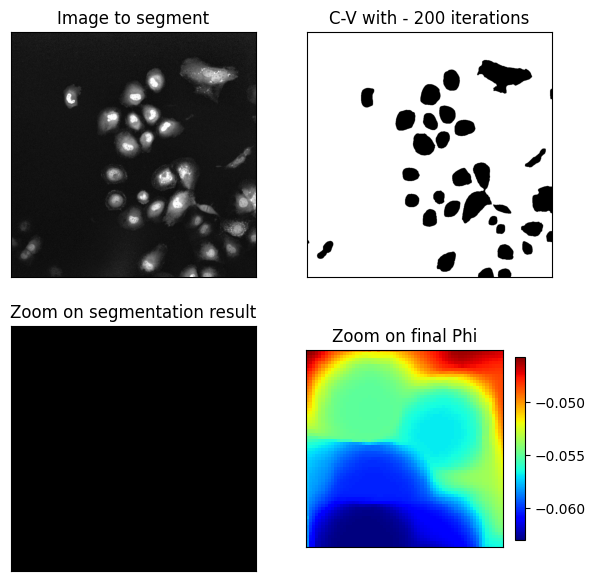

<Figure size 640x480 with 0 Axes>

Text(0.5, 1.0, 'Image avant pre-processing')

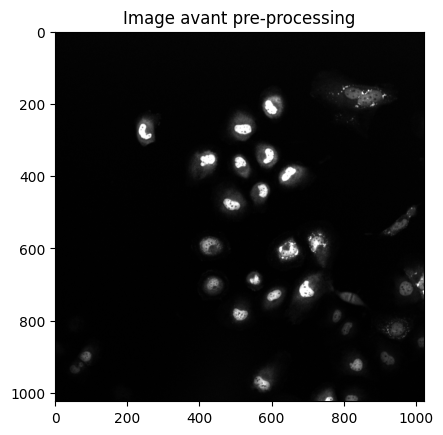

In [53]:

img_raw    = img_fluo  # img_hela[0] changed 2025 for some environments - img_cell, img_fluo
img_to_seg = img_raw 


# PARAMETERS
mu_val=0.3 ; lambda1_val=1.3; lambda2_val=1.3; 
tol_val=1e-5; dt_val=0.5

smoothing_val = 1
PRE_FILTER    = 1

Num_iter_cv_ori      = 200
Num_iter_cv_morpho   = 200

CHAN_VESE_ORI  = 1
Init_method_cv_ori       = "checkerboard" # "checkerboard" or "disk" or "small disk" (alternative to use to set init_level_set)
Init_method_cv_morpho    = "disk" # "disk" #  or "disk" or "small disk" (alternative to use to set init_level_set)


# Pre-filter (TO TURN ON IF ASKED)
if PRE_FILTER:
    img_adapteq = skimage.exposure.equalize_adapthist(img_raw, clip_limit=0.03)
    img_to_seg = img_adapteq

# Select image to segment and print information
print("min - max value in image:" , np.min(img_to_seg), np.max(img_to_seg))
print("size of image:" , img_to_seg.shape)


# run segmentation
if CHAN_VESE_ORI == 1:
    # STANDARD implementation from original paper 
    init_ls = checkerboard_level_set(img_to_seg.shape, 45) 
    
    cv = chan_vese(img_to_seg, mu=mu_val, lambda1=lambda1_val, lambda2=lambda2_val,
                   tol=tol_val, dt=dt_val, 
                   max_num_iter=Num_iter_cv_ori, init_level_set=Init_method_cv_ori,
                   extended_output=True)
    
    # Show results
    Nber_plots = 4
    fig, axes = plt.subplots(2,2,figsize=(7, 7))
    ax        = axes.ravel()
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[0].set_title("Image to segment", fontsize=12);
    ax[1].imshow(1-cv[0], cmap=plt.cm.gray)
    title = f'C-V with - {len(cv[2])} iterations'
    ax[1].set_title(title, fontsize=12)
    ax[2].imshow(1-cv[0][0:64,0:64], cmap=plt.cm.gray)
    ax[2].set_title("Zoom on segmentation result", fontsize=12);
    tmp_show =ax[3].imshow(cv[1][0:64,0:64], cmap=plt.cm.jet)
    ax[3].set_title("Zoom on final Phi", fontsize=12);
    plt.colorbar(tmp_show,ax=ax[3], shrink=0.75, location='right')

    
    print("min - max value in Seg (cv[0]):" , np.min(cv[0]), np.max(cv[0]))

else:
    # FASTER implementation implemented with morphological operators BUT LESS PRECISE
    cv      = morphological_chan_vese(img_to_seg, num_iter=Num_iter_cv_morpho, 
                                      smoothing=smoothing_val, init_level_set=Init_method_cv_morpho)
    # Show results
    Nber_plots = 2
    fig, ax = plt.subplots(1,2,figsize=(7, 7))
    ax[0].imshow(img_to_seg, cmap=plt.cm.gray)
    ax[1].imshow(1-cv, cmap=plt.cm.gray)
    title = f'C-V_morph with - {Num_iter_cv_morpho} iterations'
    ax[1].set_title(title, fontsize=12)

for i in range(0,Nber_plots):
    ax[i].set_xticks([]), ax[i].set_yticks([]);
plt.show();
plt.figure()
plt.imshow(img_fluo, cmap='gray')
plt.title("Image avant pre-processing")

Text(0.5, 1.0, 'Ground truth of the cell image')

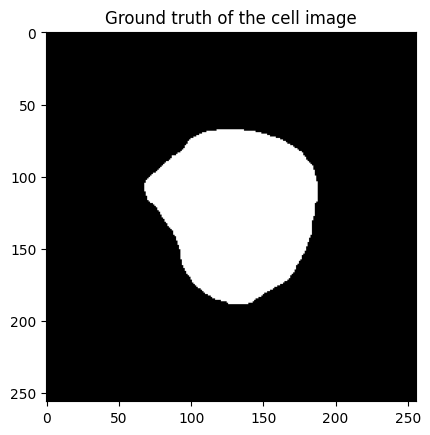

In [52]:
plt.imshow(gt_cell, cmap=plt.cm.gray)
plt.title("Ground truth of the cell image")

# Seg # 8

## Geometric active contours with balloon force

Controling level-set deformable model with speed values acting on the contour. <br>
You are provided with a tool to track the deformation patterns of the active contour over iterations. <br>

The geometric active contour routine is **morphological_geodesic_active_contour** which deforms a level set function with local speed values. It has the following **hyper-parameters** :<br>
* __Thresh_cont_val__  = 'auto'=> np.percentile(image, 40) (default if 'auto')  | pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels. (It is used in the code to cancel the balloon speed using: Threshold_mask_balloon = image > threshold / np.abs(Balloon_weight))
* __Balloon_weight__   = 1 (default) | weight of the balloon force. Can be negative to inflate/deflate
* __Smooth_cont_iter__ = 1 (default) |  Number of times a smoothing operator is applied per iteration


# TO DO:
***
__Q8.1__: Segment the __img_cell__ with the provided configuration  to __inflate__ the initial contour using Conf \#1. What is the issue when compared to the targeted ground-truth (GT) segmentation ? <br>
__Answer__: Le contour reste éloigné des contours réels de la cellule, le contour n'a pas assez évolué mais se rapproche bien des contours du fichier ```gt_cell```. Il est cependant coincé dans un minimum local du à une modification de la couleur de la cellule. <br>
***

***
__Q8.2__: Segment the __img_cell__ with the provided configuration  to __inflate__ the initial contour using Conf \#2.  <br>
 <br>
- What is the issue when compared to the targeted ground-truth (GT) segmentation ? <br>
__Answer__: la méthode ne différencie pas assez les cellules trop proches, elle englobe une cellule à proximité de la cellule centrale dans le contour final. Le résultat est donc différent de la segmentation ```gt_cell```. <br>
<br>
- What benefit(s) do you observe when using this "implicit" formulation of a deformable model versus a snake-like "explicit" model using the same initialisation set-up and a balloon force:  ? <br>
__Answer__: La méthode implicite est plus adaptée aux topologies complexes et permet plus facilement la division et la fusion des contours.  <br>
***

***
__Q8.3__: Now Segment the __img_CTabd__ with the provided configuration Conf \#3 to __deflate__ the initial contour (Adjust balloon parameter accordingly). Comment with your own words the quality and properties of the obtained segmentation: <br>
__Answer__: Malgré des artefacts, les organes de l'abdomen sont bient identifiés séparément par différents contours car les contours sur l'image à segmenter sont nettes. <br>
***

## Bonus points

***
__Q8.4a__: Check by yourself and explain why you think pre-processing using  skimage.morphology.diameter_closing help the segmentation on __img_CTabd__ ?<br>
__Answer__: <br>

__Q8.4b__: Provide a different set up (with printed code and results) with different initialisation and/or pre-processing set-up that leads to a correct segmentation of the 2 kidneys (as in the ground truth). <br>
__Answer__: <br>
***

min - max value in image to seg: 0.3062454376394709 1.0
size of image to seg: (311, 311)
threshold used in morphological_geodesic 0.7199191982831742


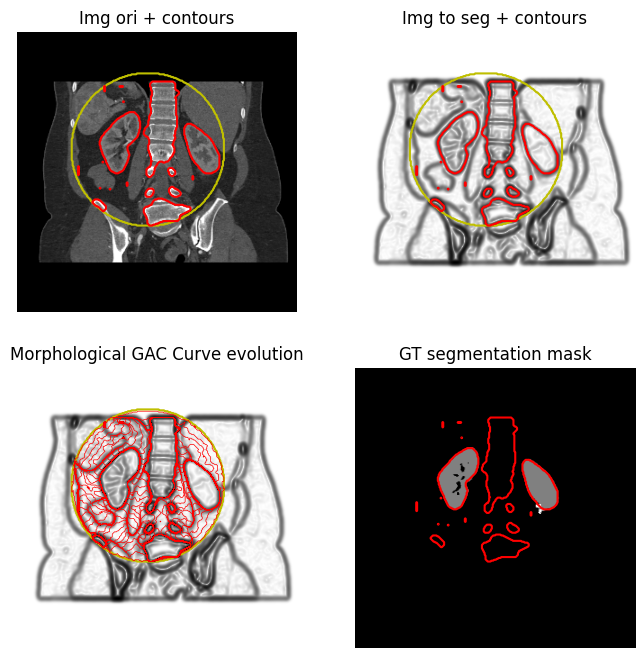

In [49]:
# img_cell:
#img_raw    = img_cell ; 
#gt_seg     = gt_cell

# img_CTabd:
img_raw    = img_CTabd ; 
gt_seg     = gt_CTabd


# Select img to segment
img_to_seg = img_raw; 

# Conf #1: Disk parameters to initialise shape for INFLATION on img_cell 
#r0 = 130;  c0 = 125 ; R0 = 30  # inflate
# Conf #2: Disk parameters to initialise shape for INFLATION on img on img_cell 
#r0 = 130;  c0 = 125 ; R0 = 45  # inflate
# Conf #3: Disk parameters to initialise shape for DEFLATION on img
r0 = 130;  c0 = 145 ; R0 = 85  # deflate TO KEEP ON CTabd

# Hyper-parameter for Balloon velocity:
Balloon_weight   = -1 ; # +1 or -1 to Inflate or deflate

# Additional Hyper-parameters for geodesic deformable model:
Threshold_contour_level = 20; 
Smooth_cont_iter        = 1 ; # Number of times a smoothing operator is applied per iteration
Niter_snake             = 600

# Hyper-parameter for preparing the input data:
INV_EDGE_MAP = 1; # needed when using the Balloon force 

# Pre-processing the image with closing
img_to_seg = skimage.morphology.diameter_closing(img_to_seg, 40, connectivity=2)
    
# Inverse edge image: Compute the magnitude of the gradients in the image and 
# then inverts the result in the range [0, 1]
if INV_EDGE_MAP:
     img_to_seg = skimage.segmentation.inverse_gaussian_gradient(
                                    img_to_seg,alpha=50,sigma=2) 

# Print information
print("min - max value in image to seg:" , np.min(img_to_seg), np.max(img_to_seg))
print("size of image to seg:" , img_to_seg.shape)
  
# Set and print threshold used in morphological_geodesic_active_contour
# Areas of the inverse edge map with value < Threshold will be considered borders
Threshold_contour = np.percentile(img_to_seg, Threshold_contour_level);
Thresh_cont_val   = Threshold_contour ; # 'auto' ; # pixels < Thresh_cont_val are considered borders. The evolution of the contour will stop on these pixels.
print("threshold used in morphological_geodesic", Thresh_cont_val)


# initialise call back
evolution = []
callback = store_evolution_in(evolution)

# Initialise contour as a disk
init_ls  = skimage.segmentation.disk_level_set(img_to_seg.shape, center=[r0,c0], radius=R0)

# Run geodesic active contour 
ls       = morphological_geodesic_active_contour(
            img_to_seg, Niter_snake, init_ls, 
            smoothing=Smooth_cont_iter, balloon=Balloon_weight,
            threshold=Thresh_cont_val,
            iter_callback=callback);

# Figure with plots of level-set evolution
fig, axes = plt.subplots(2, 2, figsize=(8, 8));
ax = axes.flatten();

ax[0].imshow(img_raw, cmap="gray");
ax[0].set_axis_off();
contour = ax[0].contour(evolution[0], [0.5], colors='y');
#contour.collections[0].set_label("Contours"); #removed 2025
ax[0].contour(ls, [0.5], colors='r');
ax[0].set_title("Img ori + contours", fontsize=12);

ax[1].imshow(img_to_seg, cmap="gray");
ax[1].set_axis_off();
contour = ax[1].contour(evolution[0], [0.5], colors='y');
#contour.collections[0].set_label("Contours"); #removed 2025
#contour.set_label("Contours"); # option to update 2025
#ax[0].contour(ls, [0.5], colors='r');#removed 2025
ax[1].contour(ls, [0.5], colors='r');
ax[1].set_title("Img to seg + contours", fontsize=12);
#ax[1].contour(ls, [0.5], colors='r');#removed 2025

ax[2].imshow(img_to_seg, cmap="gray");
ax[2].set_axis_off();
contour = ax[2].contour(evolution[0], [0.5], colors='y');
#contour.collections[0].set_label("Contours"); # removed 2025
title = f'Morphological GAC Curve evolution';
ax[2].set_title(title, fontsize=12);
for i in range(1, Niter_snake-1, 5):
    contour = ax[2].contour(evolution[i], [0.5], linewidths=0.5, colors='r'); # changed 2025 0.01 to 0.5

ax[3].imshow(gt_seg, cmap="gray");
ax[3].set_axis_off();
ax[3].contour(ls, [0.5], colors='r');
ax[3].set_title("GT segmentation mask", fontsize=12);

plt.show();